# Our imports

In [1]:
import torch
import torchvision

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

# Our hyper-parameters

In [2]:
EPOCHS = 11
INPUT_SIZE = int(784 / 2)
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_TRANSFORMATIONS = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load our dataset

In [3]:
# transforms are inspired by https://nextjournal.com/gkoehler/pytorch-mnist
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms),
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_set = datasets.MNIST("data", train=True, download=True, transform=transforms)
test_set = datasets.MNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Our model

In [4]:
class RealNVP(nn.Module):
    def __init__(self, num_flows, input_size):
        super(RealNVP, self).__init__()

        # layers of "s" neural networks:
        s = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=input_size)
        )

        # layers of "t" neural networks:
        t = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),

            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),

            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),

            nn.Linear(in_features=512, out_features=input_size)
        )

        self.t = torch.nn.ModuleList([t for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([s for _ in range(num_flows)])
        
        # our prior distribution:
        self.prior_dist = torch.distributions.MultivariateNormal(torch.zeros(input_size * 2), torch.eye(input_size * 2))

        # number of transformations:
        self.num_flows = num_flows
        
        # dimensions of our input:
        self.input_size = input_size

    def coupling(self, x, idx, forward_propagation):
        x_a, x_b = x.chunk(2, 1)
        
        y_a = x_a

        s = self.s[idx](x_a)
        t = self.t[idx](x_a)

        if forward_propagation:
            y_b = (x_b - t) * torch.exp(-s)
        else:
            y_b = torch.exp(s) * x_b + t

        out = torch.cat((y_a, y_b), 1)
        
        return out, s

    def permute(self, x):
        # the following line took way more time of me, but finally i figured out the correct way to use flip method by looking at \
        # https://github.com/pytorch/pytorch/issues/18095
        return x.flip(1)

    def sample(self, batch_size):
        z = self.prior_dist.sample((batch_size, self.input_size * 2))
        z = z[:, 0, :]

        x = self.f_inverse(z)
        x = x.view(-1, self.input_size * 2)
        
        return x

    def f(self, x):
        # forward propagation, from x to z (latent space):
        
        log_jacobian_determinant = x.new_zeros(x.shape[0])
        
        z = x

        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward_propagation=True)
            z = self.permute(z)

            log_jacobian_determinant = log_jacobian_determinant - s.sum(dim=1)

        return z, log_jacobian_determinant

    def f_inverse(self, z):
        # backward propagation, from z to x:

        x = z
        
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward_propagation=False)

        return x

    def forward(self, x, reduction="avg"):
        z, log_jacobian_determinant = self.f(x)

        if reduction == "sum":
            return -(self.prior_dist.log_prob(z.cpu()) + log_jacobian_determinant.cpu()).sum().to(DEVICE)
        else:
            return -(self.prior_dist.log_prob(z.cpu()) + log_jacobian_determinant.cpu()).mean().to(DEVICE)

# Instantiate our model and optimizer

In [5]:
# our model:
model = RealNVP(NUM_TRANSFORMATIONS, INPUT_SIZE).to(DEVICE)

# our optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Our training and evaluation loop

In [6]:
train_loss_progress = []
test_loss_progress = []

for epoch in range(EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    model.train()

    train_loss = 0

    for i, (x, _)  in enumerate(train_loader):
        x = x.to(DEVICE)
        
        x = x.view(-1, 28 * 28)

        # dequantization ... after many failed attempts, i searched for solutions and found these helps and inspired by them:
        # https://github.com/fmu2/realNVP/blob/master/README.md
        # https://openreview.net/forum?id=Hyg74h05tX
        # https://github.com/e-hulten/real-nvp-2d/blob/106af8f9d3461bb6980fa0a62693f6d9eab09554/mnist.py#L35
        x = x + (1 - torch.rand(x.shape).to(DEVICE)) / 2

        # compute the loss:
        loss = model.forward(x, reduction="sum")
        train_loss += loss.item()

        # zero out the gradients from the old instance:
        optimizer.zero_grad()

        # backward pass and update the gradient:
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()

    test_loss = 0

    with torch.no_grad():
        for i, (x, _)  in enumerate(test_loader):
            x = x.to(DEVICE)
            
            x = x.view(-1, 28 * 28)
            
            x = x + (1 - torch.rand(x.shape).to(DEVICE)) / 2

            loss = model.forward(x, reduction="sum")
            test_loss += abs(loss.item())

    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)

    print(f"Training Loss: {train_loss}; Test Loss: {test_loss}")

    train_loss_progress.append(train_loss)
    test_loss_progress.append(test_loss)

    if epoch % 10 == 0:
        torch.save(model, f"{epoch}-model.pt")


Epoch: 1
Training Loss: 282.3270075439453; Test Loss: 175.96781787109376

Epoch: 2
Training Loss: 143.93537107747395; Test Loss: 118.94513303222656

Epoch: 3
Training Loss: 100.3641612141927; Test Loss: 87.31184113769531

Epoch: 4
Training Loss: 74.936141994222; Test Loss: 64.40536930541992

Epoch: 5
Training Loss: 55.59639399007161; Test Loss: 48.54106498413086

Epoch: 6
Training Loss: 42.079189169311526; Test Loss: 41.70289864501953

Epoch: 7
Training Loss: 31.276067401123047; Test Loss: 32.59045678100586

Epoch: 8
Training Loss: 22.61023610941569; Test Loss: 25.739440844726563

Epoch: 9
Training Loss: 16.589887448120116; Test Loss: 22.61172407836914

Epoch: 10
Training Loss: 9.228385382080079; Test Loss: 19.839726745605468

Epoch: 11
Training Loss: 3.933520394897461; Test Loss: 18.815446368408203


# Plotting the performance of the model during training

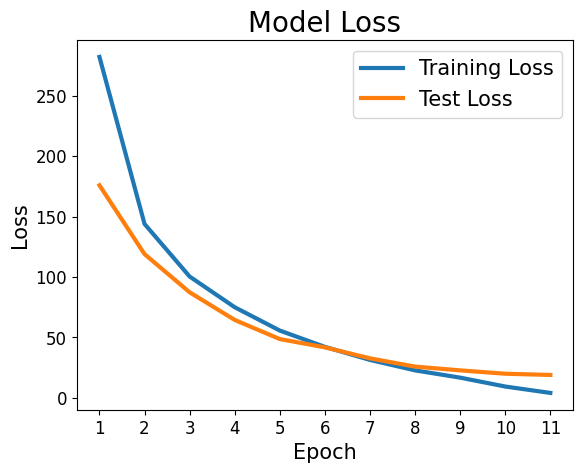

In [7]:
plt.plot(train_loss_progress, label="Training Loss", linewidth=3)
plt.plot(test_loss_progress, label="Test Loss", linewidth=3)
plt.title("Model Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.xticks(range(EPOCHS), range(1, EPOCHS + 1), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="best", fontsize=15)
plt.show()

# Generaed samples

torch.Size([16, 28, 28])


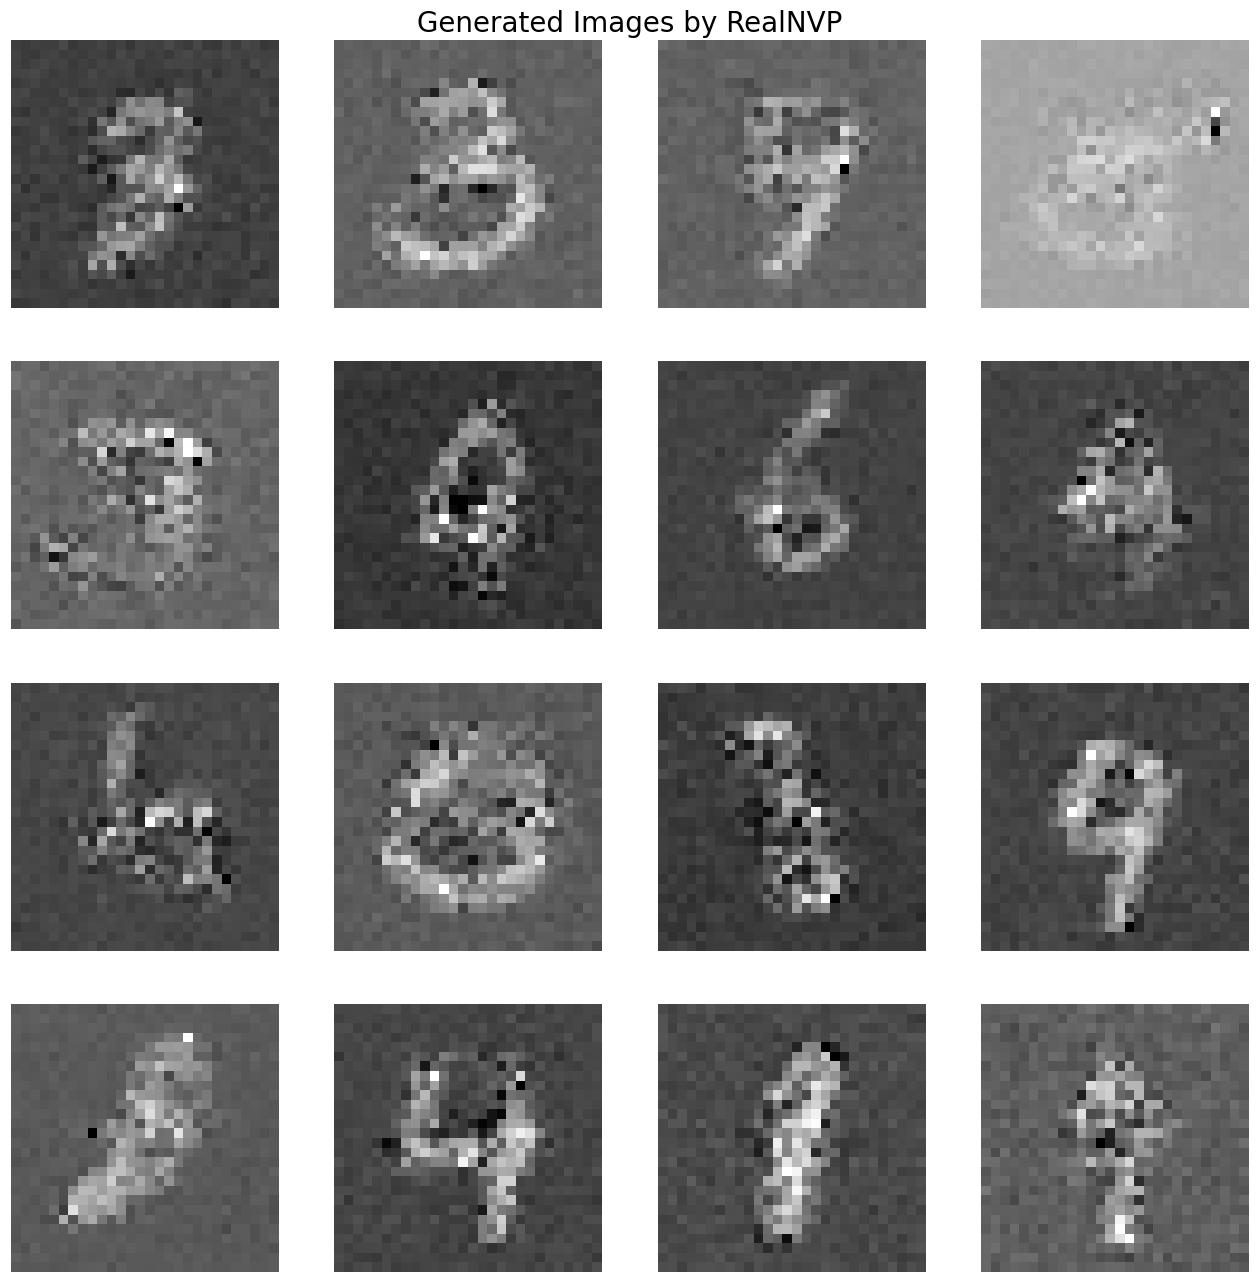

In [8]:
model.cpu()

model.eval()

x = model.sample(16)

x = x.reshape(16, 28, 28)
print(x.shape)

x = x.detach().numpy()

fig = plt.figure()

fig.set_size_inches(16, 16)

plt.title("Generated Images by RealNVP", fontsize=20)

plt.axis("off")

for i in range(1, 17):
    ax = fig.add_subplot(4, 4, i)
    
    plt.axis("off")
             
    plt.imshow(x[i - 1], cmap="gray")

plt.show()